# Fit CoFactor model for CVS Using Global Cooccurrence

In [1460]:
import itertools
import glob
import os
import sys
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from scipy import sparse
import seaborn as sns
sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 2}, font='DejaVu Serif')

/Users/hr250012/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/hr250012/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/hr250012/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/hr250012/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/hr250012/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/hr250012/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", li

In [1461]:
import cofacto
import rec_eval

### Construct the positive pairwise mutual information (PPMI) matrix

Change this to wherever you saved the pre-processed data following [this notebook](./preprocess_ML20M.ipynb).

In [1462]:
DATA_DIR = '/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro'

In [1463]:
unique_uid = list()
with open(os.path.join(DATA_DIR, 'unique_uid.txt'), 'r') as f:
    for line in f:
        unique_uid.append(line.strip())
    
unique_sid = list()
with open(os.path.join(DATA_DIR, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

In [1464]:
n_items = len(unique_sid)
n_users = len(unique_uid)

print(n_users, n_items)

15381 1998


In [1465]:
def load_data(csv_file, shape=(n_users, n_items)):
    tp = pd.read_csv(csv_file)
    timestamps, rows, cols = np.array(tp['timestamp']), np.array(tp['uid']), np.array(tp['sid'])
    seq = np.concatenate((rows[:, None], cols[:, None], np.ones((rows.size, 1), dtype='int'), timestamps[:, None]), axis=1)
    data = sparse.csr_matrix((np.ones_like(rows), (rows, cols)), dtype=np.int16, shape=shape)
    return data, seq

In [1466]:
train_data, train_raw = load_data(os.path.join(DATA_DIR, 'train.csv'))

In [1467]:
test_data, _ = load_data(os.path.join(DATA_DIR, 'test.csv'))
#test_data.data = np.ones_like(test_data.data)

In [1468]:
vad_data, vad_raw = load_data(os.path.join(DATA_DIR, 'validation.csv'))

In [1469]:
train_data.A

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [1470]:
test_data.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [1471]:
vad_data.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [1472]:
total_data=train_data+test_data+vad_data

In [1473]:
total_data.A

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [1474]:
total_data.shape

(15381, 1998)

In [1475]:
total_data.max()

322

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x3d054bda0>]],
      dtype=object)

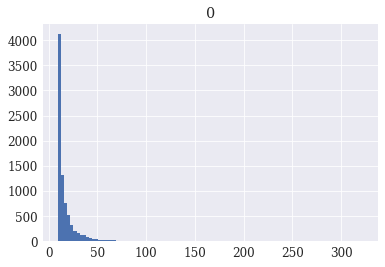

In [1594]:
pd.DataFrame(total_data[total_data>=10].A.ravel()).hist(bins=100)

In [1478]:
training_set = total_data.copy()

In [1479]:
nonzero_inds = training_set.nonzero()

In [1480]:
nonzero_inds[0].shape

(671611,)

In [1482]:
nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))

In [1483]:
nonzero_pairs

[(0, 11),
 (0, 26),
 (0, 164),
 (0, 173),
 (0, 212),
 (0, 216),
 (0, 217),
 (0, 218),
 (0, 233),
 (0, 393),
 (0, 419),
 (0, 423),
 (0, 608),
 (0, 1061),
 (0, 1195),
 (0, 1229),
 (0, 1582),
 (0, 1692),
 (0, 1897),
 (0, 1917),
 (1, 0),
 (1, 66),
 (1, 71),
 (1, 94),
 (1, 124),
 (1, 154),
 (1, 173),
 (1, 458),
 (1, 504),
 (1, 559),
 (1, 561),
 (1, 563),
 (1, 568),
 (1, 573),
 (1, 574),
 (1, 597),
 (1, 677),
 (1, 918),
 (1, 1067),
 (1, 1073),
 (1, 1109),
 (1, 1215),
 (1, 1234),
 (1, 1464),
 (1, 1469),
 (2, 19),
 (2, 26),
 (2, 27),
 (2, 28),
 (2, 157),
 (2, 182),
 (2, 246),
 (2, 383),
 (2, 390),
 (2, 393),
 (2, 402),
 (2, 415),
 (2, 580),
 (2, 601),
 (2, 753),
 (2, 844),
 (2, 1257),
 (2, 1395),
 (2, 1671),
 (2, 1705),
 (2, 1749),
 (2, 1752),
 (2, 1811),
 (2, 1813),
 (2, 1856),
 (2, 1873),
 (2, 1896),
 (2, 1897),
 (2, 1963),
 (3, 23),
 (3, 103),
 (3, 104),
 (3, 105),
 (3, 106),
 (3, 111),
 (3, 138),
 (3, 144),
 (3, 387),
 (3, 402),
 (3, 411),
 (3, 412),
 (3, 415),
 (3, 501),
 (3, 552),
 (3, 5

In [1484]:
num_samples = int(np.ceil(0.2*len(nonzero_pairs)))

In [1485]:
num_samples

134323

In [1486]:
import random

In [1487]:
random.seed(123)

In [1488]:
samples = random.sample(nonzero_pairs, num_samples)

In [1489]:
samples

[(1232, 965),
 (6411, 1930),
 (2072, 1198),
 (9760, 309),
 (6386, 1844),
 (2546, 1841),
 (904, 845),
 (9093, 1382),
 (12882, 1600),
 (13500, 164),
 (7987, 1109),
 (8186, 195),
 (1223, 306),
 (3806, 1075),
 (3201, 25),
 (8108, 284),
 (13469, 1250),
 (8026, 1141),
 (5877, 1270),
 (3912, 222),
 (32, 1610),
 (10451, 1319),
 (2078, 374),
 (14350, 851),
 (9060, 27),
 (1669, 189),
 (140, 372),
 (7552, 1442),
 (10747, 1878),
 (2405, 307),
 (1050, 1879),
 (2195, 27),
 (3374, 67),
 (2994, 1306),
 (490, 952),
 (6978, 307),
 (10320, 1022),
 (13756, 88),
 (11438, 1954),
 (6358, 1215),
 (11252, 1900),
 (874, 19),
 (7291, 1948),
 (8258, 1868),
 (12527, 1915),
 (11588, 1726),
 (4939, 1462),
 (14614, 173),
 (15338, 130),
 (12658, 524),
 (13551, 1153),
 (7548, 659),
 (281, 1745),
 (9528, 619),
 (12294, 1600),
 (10412, 553),
 (12940, 1023),
 (15325, 1158),
 (14327, 131),
 (11664, 1693),
 (12503, 305),
 (10040, 1761),
 (8979, 303),
 (12231, 761),
 (744, 180),
 (4321, 890),
 (1959, 45),
 (11680, 1466),
 (6

In [1490]:
user_inds = [index[0] for index in samples]
item_inds = [index[1] for index in samples]

In [1491]:
user_inds

[1232,
 6411,
 2072,
 9760,
 6386,
 2546,
 904,
 9093,
 12882,
 13500,
 7987,
 8186,
 1223,
 3806,
 3201,
 8108,
 13469,
 8026,
 5877,
 3912,
 32,
 10451,
 2078,
 14350,
 9060,
 1669,
 140,
 7552,
 10747,
 2405,
 1050,
 2195,
 3374,
 2994,
 490,
 6978,
 10320,
 13756,
 11438,
 6358,
 11252,
 874,
 7291,
 8258,
 12527,
 11588,
 4939,
 14614,
 15338,
 12658,
 13551,
 7548,
 281,
 9528,
 12294,
 10412,
 12940,
 15325,
 14327,
 11664,
 12503,
 10040,
 8979,
 12231,
 744,
 4321,
 1959,
 11680,
 6276,
 4060,
 8054,
 8100,
 13318,
 9370,
 1751,
 10949,
 9285,
 13754,
 8082,
 369,
 4513,
 14074,
 2092,
 15097,
 8718,
 285,
 8455,
 5480,
 9720,
 12770,
 12018,
 1414,
 15339,
 6891,
 11867,
 15135,
 5594,
 13065,
 11613,
 4231,
 3664,
 12886,
 10654,
 9085,
 11059,
 1056,
 223,
 3193,
 10933,
 4602,
 486,
 6147,
 8458,
 6509,
 10409,
 15232,
 10062,
 7,
 2570,
 14848,
 1482,
 12235,
 8522,
 2100,
 1963,
 10384,
 187,
 12873,
 9058,
 1756,
 13129,
 15253,
 9684,
 671,
 7751,
 6290,
 11329,
 773,


In [1492]:
training_set[user_inds, item_inds]=0

In [1493]:
training_set

<15381x1998 sparse matrix of type '<class 'numpy.int16'>'
	with 671611 stored elements in Compressed Sparse Row format>

In [1494]:
training_set.eliminate_zeros()

In [1495]:
training_set

<15381x1998 sparse matrix of type '<class 'numpy.int16'>'
	with 537288 stored elements in Compressed Sparse Row format>

In [1496]:
train_data=training_set.copy()

In [1497]:
test_data=training_set.copy()

In [1498]:
test_data

<15381x1998 sparse matrix of type '<class 'numpy.int16'>'
	with 537288 stored elements in Compressed Sparse Row format>

In [1499]:
test_data[:,:]=0

/Users/hr250012/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  """Entry point for launching an IPython kernel.


In [1500]:
test_data.eliminate_zeros()

In [1501]:
test_data

<15381x1998 sparse matrix of type '<class 'numpy.int16'>'
	with 0 stored elements in Compressed Sparse Row format>

In [1502]:
test_data[user_inds, item_inds]=1

/Users/hr250012/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  """Entry point for launching an IPython kernel.


In [1503]:
test_data.eliminate_zeros()

In [1504]:
test_data

<15381x1998 sparse matrix of type '<class 'numpy.int16'>'
	with 134323 stored elements in Compressed Sparse Row format>

In [1505]:
test_data.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [1506]:
purchase_per_item = np.asarray(train_data.astype('int64').sum(axis=0)).ravel()

In [1507]:
len(purchase_per_item)

1998

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x17ba832e8>]],
      dtype=object)

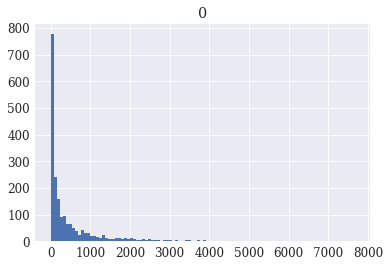

In [1509]:
pd.DataFrame(purchase_per_item).hist(bins=100)

In [1510]:
print("The mean (median)  per item is %d (%d)" % (purchase_per_item.mean(), np.median(purchase_per_item)))

The mean (median)  per item is 480 (146)


In [1511]:
user_activity = np.asarray(train_data.sum(axis=1)).ravel()

In [1512]:
print("The mean (median) items each user purchased in one transaction is %d (%d)" % (user_activity.mean(), np.median(user_activity)))



The mean (median) items each user purchased in one transaction is 62 (43)


In [1513]:
n_items = len(unique_sid)
n_users = len(unique_uid)

print(n_users, n_items)

15381 1998


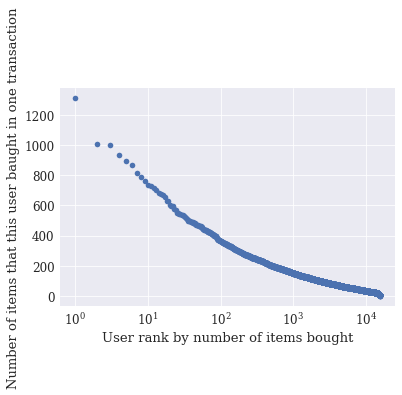

In [1514]:
plt.semilogx(1 + np.arange(n_users), -np.sort(-user_activity), 'o')
plt.ylabel('Number of items that this user baught in one transaction')
plt.xlabel('User rank by number of items bought')
pass

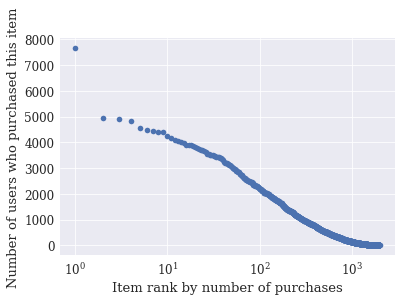

In [1515]:
plt.semilogx(1 + np.arange(n_items), -np.sort(-purchase_per_item), 'o')
plt.ylabel('Number of users who purchased this item')
plt.xlabel('Item rank by number of purchases')
pass

In [1516]:
DATA_DIR = '/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro/Masking/'

### Generate Global co-occurrence matrix

In [1519]:
def _coord_batch(lo, hi, train_data):
    rows = []
    cols = []
    for u in range(lo, hi):
        for w, c in itertools.permutations(train_data[u].nonzero()[1], 2):
            rows.append(w)
            cols.append(c)
    np.save(os.path.join(SAVE_DIR, 'coo_%d_%d.npy' % (lo, hi)),
            np.concatenate([np.array(rows)[:, None], np.array(cols)[:, None]], axis=1))
    pass

In [1520]:
from joblib import Parallel, delayed

batch_size = 5000

start_idx = range(0, n_users, batch_size)
end_idx = list(start_idx[1:]) + [n_users]

Parallel(n_jobs=8)(delayed(_coord_batch)(lo, hi, train_data) for lo, hi in zip(start_idx, end_idx))
pass

In [1521]:
X = sparse.csr_matrix((n_items, n_items), dtype='float32')

for lo, hi in zip(start_idx, end_idx):
    coords = np.load(os.path.join(DATA_DIR, 'coo_%d_%d.npy' % (lo, hi)))
    
    rows = coords[:, 0]
    cols = coords[:, 1]
    
    tmp = sparse.coo_matrix((np.ones_like(rows), (rows, cols)), shape=(n_items, n_items), dtype='float32').tocsr()
    X = X + tmp
    
    print("User %d to %d finished" % (lo, hi))
    sys.stdout.flush()

User 0 to 5000 finished
User 5000 to 10000 finished
User 10000 to 15000 finished
User 15000 to 15381 finished


Note: Don't forget to delete all the temporary coo_LO_HI.npy files

In [1522]:
np.save(os.path.join(DATA_DIR, 'coordinate_co_binary_data.npy'), X.data)
np.save(os.path.join(DATA_DIR, 'coordinate_co_binary_indices.npy'), X.indices)
np.save(os.path.join(DATA_DIR, 'coordinate_co_binary_indptr.npy'), X.indptr)

In [1523]:
1-float(X.nnz) / np.prod(X.shape)

0.4726468209951693

### Or load the pre-saved co-occurrence matrix

In [1524]:
# or co-occurrence matrix from the entire user history
dir_predix = DATA_DIR

In [373]:
data = np.load(os.path.join(dir_predix, 'coordinate_co_binary_data.npy'))
indices = np.load(os.path.join(dir_predix, 'coordinate_co_binary_indices.npy'))
indptr = np.load(os.path.join(dir_predix, 'coordinate_co_binary_indptr.npy'))

In [914]:
X = sparse.csr_matrix((data, indices, indptr), shape=(n_items, n_items))

In [1525]:
print(X.shape)

(1998, 1998)


In [1526]:
1-float(X.nnz) / np.prod(X.shape)

0.4726468209951693

In [1527]:
def get_row(Y, i):
    lo, hi = Y.indptr[i], Y.indptr[i + 1]
    return lo, hi, Y.data[lo:hi], Y.indices[lo:hi]

In [1528]:
count = np.asarray(X.sum(axis=1)).ravel()

In [1529]:
count

array([ 49188., 106115.,  60320., ...,    134.,    377.,  25368.],
      dtype=float32)

In [1530]:
n_pairs = X.data.sum()

In [1531]:
n_pairs

27381266.0

### Construct the SPPMI matrix

In [1532]:
M = X.copy()

for i in range(n_items):
    lo, hi, d, idx = get_row(M, i)
    M.data[lo:hi] = np.log(d * n_pairs / (count[i] * count[idx]))

In [1533]:
M.data[M.data < 0] = 0
M.eliminate_zeros()

In [1534]:
1-float(M.nnz) / np.prod(M.shape)

0.70096823550277

Now $M$ is the PPMI matrix. Depending on the number of negative examples $k$, we can obtain the shifted PPMI matrix as $\max(M_{wc} - \log k, 0)$

In [1535]:
# number of negative samples
k_ns = 1

M_ns = M.copy()

if k_ns > 1:
    offset = np.log(k_ns)
else:
    offset = 0.
    
M_ns.data -= offset
M_ns.data[M_ns.data < 0] = 0
M_ns.eliminate_zeros()

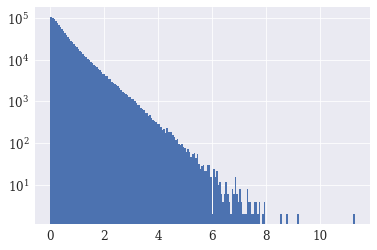

In [1536]:
plt.hist(M_ns.data, bins=200)
plt.yscale('log')
pass

In [1537]:
1-float(M_ns.nnz) / np.prod(M_ns.shape)

0.70096823550277

In [1538]:
M_ns.A

array([[0.        , 0.07756213, 0.        , ..., 0.        , 0.3897195 ,
        0.        ],
       [0.07756213, 0.        , 0.09863149, ..., 0.        , 0.31399292,
        0.        ],
       [0.        , 0.09863149, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 6.2952847 ,
        0.        ],
       [0.3897195 , 0.31399292, 0.        , ..., 6.2952847 , 0.        ,
        2.150493  ],
       [0.        , 0.        , 0.        , ..., 0.        , 2.150493  ,
        0.        ]], dtype=float32)

### Train the model

In [1539]:
scale = 0.03

n_components = 100
max_iter = 20
n_jobs = 8
lam_theta = lam_beta = 1e-5 * scale
lam_gamma = 1e-5
c0 = 1. * scale
c1 = 10. * scale

save_dir = os.path.join(DATA_DIR, 'ML20M_ns%d_scale%1.2E' % (k_ns, scale))

In [1540]:
import cofacto
coder = cofacto.CoFacto(n_components=n_components, max_iter=max_iter, batch_size=1000, init_std=0.01, n_jobs=n_jobs, 
                        random_state=98765, save_params=True, save_dir=save_dir, early_stopping=True, verbose=True, 
                        lam_theta=lam_theta, lam_beta=lam_beta, lam_gamma=lam_gamma, c0=c0, c1=c1)

In [1011]:
print(train_data)

  (0, 13)	1
  (0, 28)	1
  (0, 167)	6
  (0, 176)	1
  (0, 215)	1
  (0, 219)	1
  (0, 220)	1
  (0, 236)	2
  (0, 396)	1
  (0, 422)	1
  (0, 426)	1
  (0, 616)	1
  (0, 1071)	1
  (0, 1211)	3
  (0, 1248)	1
  (0, 1258)	1
  (0, 1294)	1
  (0, 1303)	1
  (0, 1641)	2
  (0, 1934)	3
  (1, 1)	1
  (1, 4)	1
  (1, 68)	1
  (1, 73)	1
  (1, 126)	1
  :	:
  (15412, 619)	2
  (15412, 623)	1
  (15412, 675)	2
  (15412, 762)	1
  (15412, 848)	1
  (15412, 1058)	1
  (15412, 1067)	1
  (15412, 1163)	2
  (15412, 1166)	3
  (15412, 1271)	11
  (15412, 1276)	1
  (15412, 1638)	1
  (15412, 1641)	1
  (15412, 1721)	1
  (15412, 1726)	1
  (15412, 1757)	1
  (15412, 1769)	1
  (15412, 1770)	1
  (15412, 1776)	1
  (15412, 1847)	1
  (15412, 1878)	2
  (15412, 1915)	1
  (15412, 1984)	1
  (15412, 1992)	1
  (15412, 2000)	1


In [1541]:
np.savetxt('/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro/Masking/Glob_coo_mat.csv',M_ns.A)

In [1542]:
coder.fit(train_data, M_ns, vad_data=vad_data, batch_users=5000, k=100)

ITERATION #0
	Updating user factors: time=0.88
	Updating item factors: time=0.61
	Updating context factors: time=0.42
	Updating bias terms: time=0.37
	Validation NDCG@k: 0.02104
ITERATION #1
	Updating user factors: time=0.62
	Updating item factors: time=0.59
	Updating context factors: time=0.41
	Updating bias terms: time=0.35
	Validation NDCG@k: 0.03322
ITERATION #2
	Updating user factors: time=0.62
	Updating item factors: time=0.58
	Updating context factors: time=0.40
	Updating bias terms: time=0.32
	Validation NDCG@k: 0.03757
ITERATION #3
	Updating user factors: time=0.61
	Updating item factors: time=0.58
	Updating context factors: time=0.40
	Updating bias terms: time=0.38
	Validation NDCG@k: 0.03906
ITERATION #4
	Updating user factors: time=0.64
	Updating item factors: time=0.60
	Updating context factors: time=0.44
	Updating bias terms: time=0.34
	Validation NDCG@k: 0.03974
ITERATION #5
	Updating user factors: time=0.61
	Updating item factors: time=0.59
	Updating context factors: ti

CoFacto(batch_size=1000, dtype='float32', early_stopping=True, init_std=0.01,
    max_iter=20, n_components=100, n_jobs=8, random_state=98765,
    save_dir='/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro/Masking/ML20M_ns1_scale3.00E-02',
    save_params=True, verbose=True)

In [1543]:
n_params = len(glob.glob(os.path.join(save_dir, '*.npz')))

params = np.load(os.path.join(save_dir, 'CoFacto_K%d_iter%d.npz' % (n_components, n_params - 1)))
U, V = params['U'], params['V']

In [1544]:
U.shape

(15381, 100)

In [1545]:
V.shape

(1998, 100)

In [1546]:
test_data

<15381x1998 sparse matrix of type '<class 'numpy.int16'>'
	with 134323 stored elements in Compressed Sparse Row format>

In [1547]:
test_data.eliminate_zeros()

In [1548]:
test_data

<15381x1998 sparse matrix of type '<class 'numpy.int16'>'
	with 134323 stored elements in Compressed Sparse Row format>

In [1549]:
print('Test Recall@20: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=20, vad_data=vad_data))
print('Test Recall@50: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=50, vad_data=vad_data))
print('Test NDCG@100: %.4f' % rec_eval.normalized_dcg_at_k(train_data, test_data, U, V, k=100, vad_data=vad_data))
print('Test MAP@100: %.4f' % rec_eval.map_at_k(train_data, test_data, U, V, k=100, vad_data=vad_data))

/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/code/rec_eval.py:184: RuntimeWarning: invalid value encountered in true_divide
  recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))


Test Recall@20: 0.0871
Test Recall@50: 0.1624


/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/code/rec_eval.py:257: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


Test NDCG@100: 0.1256
Test MAP@100: 0.0310


In [1550]:
np.savez('CoFactor_K100_ML20M.npz', U=U, V=V)

In [1551]:
R=U.dot(V.T)

In [1552]:
R.shape

(15381, 1998)

In [1553]:
R.min()

-24.556347

In [1554]:
R.max()

274.5157

In [1432]:
train_data.shape

(15413, 2036)

In [1793]:
seg2id = dict((sid, i) for (i, sid) in enumerate(unique_sid)) 
user2id = dict((uid, i) for (i, uid) in enumerate(unique_uid))

In [1794]:
id2seg = dict((i, sid) for (i, sid) in enumerate(unique_sid))
id2user = dict((i, uid) for (i, uid) in enumerate(unique_uid))

In [1557]:
V

array([[-0.0389803 , -0.04131758, -0.05419049, ...,  0.01897755,
        -0.03356067,  0.05030379],
       [-0.00388172, -0.03734571, -0.03893712, ..., -0.02063298,
        -0.03280751,  0.02348219],
       [-0.00401386, -0.02863842, -0.03545198, ..., -0.0415576 ,
        -0.07531264,  0.00256723],
       ...,
       [ 0.01086153,  0.08587707,  0.09454407, ...,  0.05310918,
         0.10325363, -0.02452494],
       [ 0.00962957,  0.06829726,  0.07822631, ...,  0.04270635,
         0.08498259, -0.02204664],
       [ 0.00736274,  0.0506641 , -0.00148351, ..., -0.0450753 ,
        -0.00828366,  0.02072164]], dtype=float32)

In [1790]:
from sklearn.preprocessing import MinMaxScaler  

In [1791]:

#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------
def recommend(original_user_id, data_sparse, user_vecs, item_vecs, user2id, seg2id, id2user, id2seg, num_items=10):
    """Recommend items for a given user given a trained model

    Args:
    user_id (int): The id of the user we want to create recommendations for.

    data_sparse (csr_matrix): Our original training data.

    user_vecs (csr_matrix): The trained user x features vectors

    item_vecs (csr_matrix): The trained item x features vectors

    id2seg (dictionary): Used to map ids to segment names

    num_items (int): How many recommendations we want to return:

    Returns:
    recommendations (pandas.DataFrame): DataFrame with num_items artist names and scores

    """
    user_id = user2id[str(original_user_id)]
    # Get all interactions by the user
    user_interactions = data_sparse[user_id,:].toarray()
 
    # We don't want to recommend items the user has consumed. So let's
    # set them all to 0 and the unknowns to 1.
    user_interactions = user_interactions.reshape(-1) + 1 #Reshape to turn into 1D array
    user_interactions[user_interactions > 1] = 0
 
    # This is where we calculate the recommendation by taking the
    # dot-product of the user vectors with the item vectors.
    rec_vector = user_vecs[user_id,:].dot(item_vecs.T)
 
    # Let's scale our scores between 0 and 1 to make it all easier to interpret.
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = rec_vector_scaled
 
    # Get all the segments indices in order of recommendations (descending) and
    # select only the top "num_items" items.
    item_idx = np.argsort(recommend_vector)[::-1][:num_items]
 
    top_n_recommended_items = []
    item_scores = []
 
    # Loop through our recommended segments indicies and look up the actial artist name
    top_n_recommended_items = list(map(lambda x: id2seg[x], item_idx))
    top_n_recommended_items
 

    for item_id in item_idx:
        item_scores.append(recommend_vector[item_id])
 
    # Create a new dataframe with recommended artist names and scores
    recommendations = pd.DataFrame({'items': top_n_recommended_items, 'score': item_scores})
 
    return recommendations.sort_values(['score'], ascending=[False])
 



In [1795]:
recommendations = recommend(207885,train_data,U,V,user2id,seg2id,id2user,id2seg,10)
recommendations

KeyError: '207885'

In [1033]:
user2id['15']

2

In [1034]:
items=test_data.A[2].nonzero()

In [1035]:
items_v=vad_data.A[2].nonzero()

In [1036]:
print(items)

(array([  29,   30,  249,  762, 1303, 1306, 1426, 1739, 1848, 2000]),)


In [1037]:
type(items)

tuple

In [1038]:
items[0]

array([  29,   30,  249,  762, 1303, 1306, 1426, 1739, 1848, 2000])

In [1039]:
test_i=np.array(list((map(lambda x: id2seg[x], np.array(items[0])))))

In [1040]:
print(test_i.reshape(-1,1))

[['1-11-3-2']
 ['1-11-3-27']
 ['1-46-20-20']
 ['3-26-12-22']
 ['4-35-3-41']
 ['4-35-3-44']
 ['4-58-15-59']
 ['6-90-2-8']
 ['7-4-1-5']
 ['7-9-20-21']]


In [1041]:
recommendations

,items,score
0,5-41-1-1,1.000000
1,2-80-4-19,0.826938
2,7-16-2-2,0.403825
3,5-41-41-43,0.362076
4,2-80-2-9,0.347663
5,2-80-2-3,0.343628
6,2-80-2-5,0.336219
7,4-35-2-27,0.335383
8,2-13-4-28,0.330961
9,4-58-27-92,0.318221


In [1799]:
#------------------------------
# FIND SIMILAR ITEMS
#------------------------------
def get_similar_items(item_id, number_of_similar_items, U, V, id2user, id2seg):
    item_vecs = V
 
    #item_id = item_id
    item_id = seg2id[str(item_id)]
 
    # Get the item row for item_id
    item_vec = item_vecs[item_id].T
 
    n = number_of_similar_items
    # Calculate the similarity score between item_id  and other items
    # and select the top n most similar.
    scores = item_vecs.dot(item_vec).reshape(1,-1)[0]
    top_10 = np.argsort(scores)[::-1][:n]
 
    items = []
    item_scores = []
 
    top_10_similar_items = list(map(lambda x: id2seg[x], top_10))
    top_10_similar_items
 
    for item_id in top_10:
        item_scores.append(scores[item_id])
 
    similar = pd.DataFrame({'items': top_10_similar_items, 'item_score': item_scores})
 
    return similar

In [1802]:
items_similar_to_id_1 = get_similar_items('5-39-65-65',15,U,V,id2user,id2seg)

In [1803]:
items_similar_to_id_1

,items,item_score
0,3-21-76-76,0.101641
1,4-58-8-40,0.101177
2,5-41-55-55,0.100905
3,3-30-81-88,0.100694
4,2-13-60-62,0.100177
5,3-91-46-46,0.099713
6,3-91-45-45,0.099604
7,3-91-5-36,0.099075
8,4-95-7-66,0.097892
9,1-7-18-18,0.097717


In [1560]:
R.max()

274.5157

In [1561]:
R

array([[-3.9461300e-01,  1.5027294e+00,  4.6565396e-01, ...,
        -2.4343534e-04,  2.9762087e-02, -1.0446249e+00],
       [ 8.8167894e-01,  2.8746274e-01, -7.3014148e-02, ...,
         6.1034755e-04, -2.1013415e-03, -5.4904026e-01],
       [ 4.5722209e-02,  2.7376041e-01, -4.0267941e-01, ...,
         1.8152273e-03, -4.3542758e-03,  5.8357853e-01],
       ...,
       [-1.5084189e-01,  1.0873905e+00,  1.6420561e+00, ...,
        -2.0267203e-02, -8.4950440e-02, -5.1189917e-01],
       [ 4.8680249e-01,  7.6020741e-01,  1.3851244e+00, ...,
         2.0731069e-02,  1.2426360e-01, -6.1835426e-01],
       [-8.2361661e-02,  3.1619042e-01,  2.2494797e-01, ...,
        -1.9682018e-02, -3.3642866e-02, -1.8895197e-01]], dtype=float32)

In [1562]:
len(user_inds)

134323

In [1071]:
R

array([[ 0.17530918, -0.08242168,  0.7851609 , ..., -0.00266128,
         0.00942642,  0.11653311],
       [ 0.14186405,  0.79749304,  0.4662452 , ..., -0.02016496,
        -0.04380751, -0.346925  ],
       [ 0.30229157, -0.44046527, -0.18869235, ...,  0.00454597,
         0.00241695, -0.1602581 ],
       ...,
       [-0.14701934,  0.08284428,  0.60803735, ...,  0.00833126,
        -0.00722518, -0.08061367],
       [ 0.14988805, -0.22616178,  0.72415   , ..., -0.00305443,
         0.07827345, -0.2603975 ],
       [ 0.02551959, -0.5216245 , -0.21675089, ..., -0.00765551,
        -0.03177692, -0.22684287]], dtype=float32)

In [1741]:
R.max()

274.5157

In [1742]:
R.min()

-24.556347

In [1804]:
R1 = R.copy()

(array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        9.1230000e+03, 3.8576000e+04, 4.6194000e+04, 5.4976000e+04,
        6.6277000e+04, 8.0287000e+04, 9.9079000e+04, 1.2465300e+05,
        1.5666000e+05, 2.0180500e+05, 2.6649800e+05, 3.6141200e+05,
        5.2358900e+05, 8.5523400e+05, 2.0560660e+06, 1.0886742e+07,
        5.2466530e+06, 2.5908140e+06, 1.6480640e

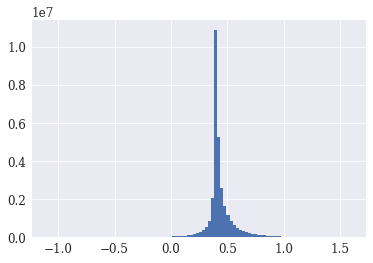

In [1828]:
matplotlib.pyplot.hist(R1.ravel(),bins=100,range=(-1.1,1.6))

In [1747]:
#R1[R1<-1]=-1.01

In [1805]:
R1[R1<-1]=0

In [1806]:
#R1[R1>1.5]=1.51

In [1807]:
R1[R1>1.5]=0

In [1808]:
R1.min()

-0.99999917

In [1811]:
R1.max()

2.499999

In [1810]:
R1=R1+0.99999917

In [1812]:
R1=R1/2.499999

In [1813]:
R1.min()

0.0

In [1814]:
R1.mean()

0.43648654

In [1815]:
np.median(R1)

0.4105652

In [1283]:
user_inds

[1051,
 5389,
 1752,
 8223,
 5365,
 2144,
 746,
 7644,
 10809,
 11335,
 6697,
 6870,
 1039,
 3182,
 2680,
 6801,
 11306,
 6729,
 14162,
 4929,
 3260,
 28,
 8789,
 1760,
 12056,
 7609,
 1389,
 117,
 6356,
 14791,
 9042,
 2042,
 875,
 1855,
 13466,
 2830,
 2513,
 407,
 5886,
 8680,
 11561,
 9595,
 5343,
 9446,
 719,
 6154,
 6917,
 10511,
 9729,
 4159,
 12273,
 12900,
 10628,
 11392,
 6354,
 232,
 8051,
 13043,
 10332,
 8752,
 13811,
 10856,
 12891,
 13456,
 12032,
 9798,
 10489,
 13495,
 8475,
 7536,
 10276,
 615,
 15228,
 13034,
 3640,
 14648,
 1658,
 9811,
 13296,
 5269,
 3400,
 6748,
 6791,
 11173,
 7920,
 1458,
 14596,
 9205,
 7839,
 11554,
 6773,
 305,
 3794,
 11826,
 1769,
 12686,
 7307,
 236,
 7067,
 4603,
 8195,
 10720,
 10086,
 14605,
 1191,
 12901,
 5802,
 9958,
 12720,
 14536,
 4690,
 10965,
 9748,
 3556,
 3063,
 10815,
 8963,
 7632,
 15183,
 9293,
 880,
 185,
 2674,
 9199,
 3879,
 405,
 5155,
 7071,
 13815,
 5473,
 8752,
 12799,
 8493,
 7,
 2162,
 12467,
 1238,
 10282,
 7141,

In [1816]:
def create_pred_array(i,j):
    return R1[i,j]

In [1817]:
def create_test_array(i,j):
    return test_data[i,j] 


In [1818]:
test_array_final = Parallel(n_jobs=8)(delayed(create_test_array) (i,j) for i, j in samples)
pred_array_final = Parallel(n_jobs=8)(delayed(create_pred_array) (i,j) for i, j in samples)

In [1819]:
min(pred_array_final)

2.9540073e-05

In [1820]:
max(pred_array_final)

1.0

In [1821]:
test_array_final_2 = np.squeeze(np.asarray(total_data[np.nonzero(total_data == 0)]))
pred_array_final_2 = R1[np.nonzero(total_data == 0)]

In [1822]:
test_array_for_auc = np.concatenate([test_array_final,test_array_final_2])
pred_array_for_auc = np.concatenate([pred_array_final,pred_array_final_2])

In [1823]:
pred_array_for_auc.min()

0.0

In [1824]:
pred_array_for_auc.max()

1.0

In [1825]:
pred_array_for_auc

array([0.8812119 , 0.33111966, 0.39999983, ..., 0.392127  , 0.38654265,
       0.324419  ], dtype=float32)

In [1826]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

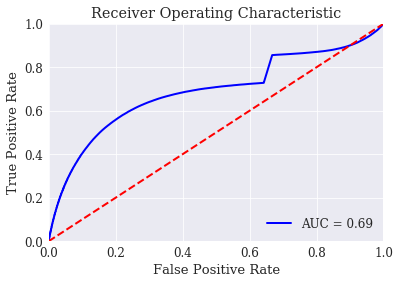

In [1827]:
preds = pred_array_for_auc
fpr, tpr, threshold = metrics.roc_curve(test_array_for_auc, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [1098]:
threshold

array([0.14055133, 0.09485922, 0.09467751, ..., 0.01089351, 0.01085395,
       0.        ], dtype=float32)

test_array.max()

In [1214]:
test_array_final

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [1215]:
pred_array_final

[0.07937498,
 0.08287254,
 0.07952756,
 0.07932912,
 0.081848815,
 0.0775456,
 0.07925241,
 0.079466015,
 0.07948291,
 0.08121788,
 0.08083786,
 0.08068463,
 0.0811399,
 0.07986536,
 0.08153782,
 0.08355833,
 0.08558283,
 0.0800546,
 0.08777052,
 0.079467356,
 0.08000284,
 0.07973824,
 0.077525415,
 0.089641355,
 0.081442215,
 0.08153646,
 0.08084813,
 0.07571791,
 0.080032155,
 0.086290404,
 0.08189494,
 0.05672413,
 0.07853897,
 0.079984404,
 0.0781943,
 0.07959902,
 0.07940462,
 0.070335336,
 0.08016348,
 0.07551525,
 0.07957724,
 0.07918362,
 0.08224909,
 0.08601701,
 0.08078001,
 0.10625982,
 0.08773036,
 0.07963288,
 0.079812266,
 0.09528341,
 0.07757471,
 0.08056013,
 0.079448864,
 0.07142238,
 0.08219282,
 0.086548686,
 0.08021867,
 0.079790585,
 0.080187306,
 0.07889336,
 0.07975796,
 0.079177245,
 0.07916533,
 0.08034783,
 0.08333948,
 0.08067354,
 0.07981155,
 0.082210876,
 0.08878337,
 0.08402276,
 0.07978487,
 0.079052605,
 0.08009717,
 0.08328558,
 0.08210385,
 0.0817481,

(array([ 3235.,   121.,   115.,   128.,   144.,   136.,   154.,   146.,
          165.,   153.,   196.,   188.,   202.,   215.,   236.,   209.,
          246.,   264.,   302.,   319.,   326.,   332.,   362.,   374.,
          376.,   468.,   464.,   577.,   572.,   575.,   641.,   728.,
          754.,   893.,   958.,  1027.,  1170.,  1272.,  1566.,  2031.,
         2639.,  2918.,  3075.,  3199.,  3202.,  3244.,  3200.,  3130.,
         2956.,  2940.,  2956.,  2897.,  2850.,  2683.,  2581.,  2555.,
         2484.,  2297.,  2229.,  2180.,  2041.,  2033.,  1971.,  1831.,
         1884.,  1638.,  1633.,  1553.,  1559.,  1486.,  1396.,  1344.,
         1285.,  1264.,  1186.,  1118.,  1080.,  1129.,   984.,   921.,
          945.,   889.,   875.,   838.,   755.,   716.,   678.,   658.,
          613.,   660.,   584.,   558.,   559.,   563.,   487.,   505.,
          486.,   413.,   448., 14202.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 

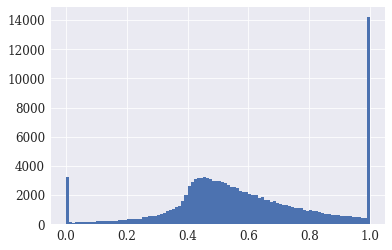

In [1774]:
matplotlib.pyplot.hist(pred_array_final,bins=100)

(array([ 284341.,   13643.,   14232.,   15312.,   16536.,   17332.,
          18784.,   19786.,   21425.,   22854.,   24714.,   26334.,
          28131.,   30607.,   33061.,   35811.,   38784.,   42093.,
          46158.,   50261.,   54591.,   59774.,   65294.,   72359.,
          79468.,   88248.,   97901.,  109770.,  122423.,  138064.,
         157925.,  181938.,  211763.,  251183.,  306151.,  387523.,
         519526.,  776295., 1463923., 3923836., 4622540., 2852810.,
        1920825., 1418679., 1110132.,  904211.,  754285.,  644666.,
         555349.,  485366.,  426357.,  378231.,  336127.,  300920.,
         270492.,  243560.,  219757.,  199970.,  181982.,  165073.,
         150928.,  137741.,  125967.,  115507.,  105831.,   98045.,
          90034.,   83330.,   77190.,   70772.,   66172.,   61422.,
          56954.,   52922.,   49293.,   46125.,   42954.,   40149.,
          37545.,   35155.,   32735.,   30777.,   28719.,   26985.,
          25668.,   23884.,   22446.,   21060., 

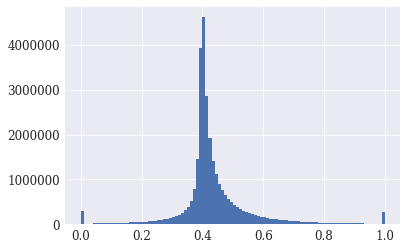

In [1775]:
matplotlib.pyplot.hist(pred_array_final_2,bins=100)

In [1776]:
pred_array1=np.array(pred_array_final.copy())

In [1777]:
pd.DataFrame(pred_array1>=0.44)[0].value_counts()

True     100152
False     34171
Name: 0, dtype: int64

In [1778]:
100152/(100152+34171)

0.745605741384573

In [1779]:
R1.ravel().mean()

0.44119972

In [1780]:
np.median(R1)

0.41251224

In [1781]:
pred_array_for_auc

array([0.87818646, 0.3324602 , 0.        , ..., 0.39298335, 0.3874433 ,
       0.3258127 ], dtype=float32)

In [1782]:
predictions=pred_array_for_auc.copy()

In [1783]:
predictions[predictions<0.44]=0

In [1784]:
predictions[predictions>=0.44]=1

In [1785]:
predictions

array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [1786]:
from sklearn.metrics import confusion_matrix

In [1787]:
confusion_matrix(test_array_for_auc, predictions)

array([[20683008,  9376619],
       [   34171,   100152]])

In [1788]:
100152/(100152+34171)

0.745605741384573

In [1789]:
(20683008+100152)/(20683008+100152+9376619+34171)

0.6883219982811126